In [1]:
# Global Suicide Rate Analysis
%matplotlib inline

# Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
from config import gkey
import requests
import json
import googlemaps
import gmaps
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from scipy import stats
init_notebook_mode(connected=True)

gmaps.configure(api_key=gkey)

In [2]:
# Read master suicide rates data into dataframe
master_data_df = pd.read_csv("./source_data/master.csv")

# print(len(master_data_df))

master_data_df.head()


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [3]:
# Cleaningup raw data
master_data_df.columns

master_data_df = master_data_df.drop_duplicates()

master_data_df.rename(columns={' gdp_for_year ($) ': 'gdp_for_year ($)'}, inplace=True)



In [4]:
# Filtering 10 years data (2006-2015) 
ten_yr_df = master_data_df.loc[(master_data_df["year"]>2005) & (master_data_df["year"]<2016)]



In [6]:
# Determining Top 10 countries with higher suicide numbers
country_grp = ten_yr_df.groupby(["country"])

country_grp_df = pd.DataFrame({"total_suicides_no": country_grp["suicides_no"].sum()})

country_grp_df = country_grp_df.reset_index()

country_grp_df = country_grp_df.sort_values(["total_suicides_no"], ascending=False)

country_grp_df.head(10)


,country,total_suicides_no
92,United States,387385
71,Russian Federation,334082
45,Japan,278985
69,Republic of Korea,138480
34,Germany,98697
15,Brazil,97856
32,France,90413
89,Ukraine,81876
65,Poland,59658
55,Mexico,52100


In [7]:
suicide_num=country_grp_df['total_suicides_no']
target_country=country_grp_df['country']
suicide_df=pd.DataFrame({
                        "Country":target_country,
                        "Lat":"",
                        "Lng":"",
                        "Suicide-No.":suicide_num
})
suicide_df
params = {"key": gkey}
for index,row in suicide_df.iterrows():   
# Build URL using the Google Maps API
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    country=row['Country']
    params['address']={country}
    # Run request
    response = requests.get(base_url, params=params)
    
    response_json=response.json()
    #extracting lat lng
    suicide_df.loc[index, "Lat"] = response_json["results"][0]["geometry"]["location"]["lat"]
    suicide_df.loc[index, "Lng"] = response_json["results"][0]["geometry"]["location"]["lng"]
    
export_csv=suicide_df.to_csv("./source_data/Country_Lat_Lng.csv",encoding="utf-8",index=None,header=True)


In [8]:
#saving locations lat and long
locations=suicide_df[['Lat','Lng']].astype(float)

rates=suicide_df["Suicide-No."].astype(float)


In [9]:
# Yearly population by country - combining population of both male and female, all ages (all countries, 10 years)
country_yr_grp = ten_yr_df.groupby(["country","year"])

country_yr_grp_df = pd.DataFrame({"country_yearly_population": country_yr_grp["population"].sum()})

country_yr_grp_df.head(20)

country_yearly_population
country             year                           
Albania             2006                    2780176
                    2007                    2770344
                    2008                    2757059
                    2009                    2745735
                    2010                    2736025
Antigua and Barbuda 2006                      81973
                    2007                      83131
                    2008                      84273
                    2009                      85405
                    2012                      88703
                    2013                      89779
                    2014                      90837
                    2015                      91889
Argentina           2006                   35918886
                    2007                   36315492
                    2008                   36733520
                    2009                   37158001
                    2010                   37578454
                    2011                   38015739
                    2012                   38441778

In [12]:
# Filtering 10 year data for top 10 countries
top_country_ten_yr_df = pd.merge(ten_yr_df,country_grp_df.iloc[0:10], how='inner', on='country')

# Merging coutry_yearly_population for top 10 countries
top_country_ten_yr_df = pd.merge(top_country_ten_yr_df, country_yr_grp_df, how='inner', on=['country','year']) 

top_country_ten_yr_df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation,total_suicides_no,country_yearly_population
0,Brazil,2006,male,75+ years,275,1575798,17.45,Brazil2006,NaN,"1,107,640,297,890",6403,Silent,97856,172974722
1,Brazil,2006,male,55-74 years,1112,9247477,12.02,Brazil2006,NaN,"1,107,640,297,890",6403,Silent,97856,172974722
2,Brazil,2006,male,35-54 years,2536,22709135,11.17,Brazil2006,NaN,"1,107,640,297,890",6403,Boomers,97856,172974722
3,Brazil,2006,male,25-34 years,1537,15717099,9.78,Brazil2006,NaN,"1,107,640,297,890",6403,Generation X,97856,172974722
4,Brazil,2006,male,15-24 years,1293,18063460,7.16,Brazil2006,NaN,"1,107,640,297,890",6403,Millenials,97856,172974722


In [13]:
#grouping by the countries to get the list suicide numbers anfd rates/100K
countries=top_country_ten_yr_df.groupby('country')
country=countries['suicides/100k pop'].sum()
raw_numbers=countries['suicides_no'].sum()


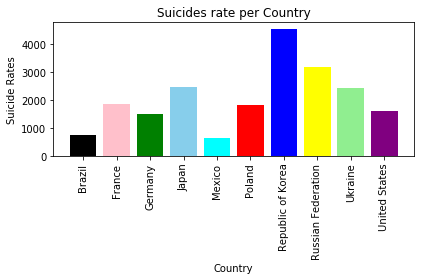

In [14]:
#Bar chart by suicide rates
countries_list=np.arange(len(countries))
plt.bar(countries_list,country,color=['black', 'pink', 'green', 'skyblue', 'cyan','red',
                                      'blue','yellow','lightgreen','purple'],align="edge")
tick_locations = [value+0.4 for value in countries_list]
plt.xticks(tick_locations,['Brazil','France','Germany','Japan','Mexico',
                           'Poland','Republic of Korea','Russian Federation','Ukraine','United States'],rotation="vertical")
plt.title("Suicides rate per Country")
plt.xlabel("Country")
plt.ylabel("Suicide Rates")
plt.tight_layout()
#plt.grid()
plt.savefig("./Images/suiciderate_barchart.png")
plt.show()

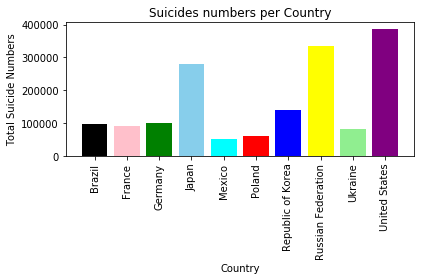

In [27]:
#bar chart by suicide numbers
countries_list=np.arange(len(countries))
plt.bar(countries_list,raw_numbers,color=['black', 'pink', 'green', 'skyblue', 'cyan','red',
                                      'blue','yellow','lightgreen','purple'],align="edge")
tick_locations = [value+0.4 for value in countries_list]
plt.xticks(tick_locations,['Brazil','France','Germany','Japan','Mexico',
                           'Poland','Republic of Korea','Russian Federation','Ukraine','United States'],rotation="vertical")
plt.title("Suicides numbers per Country")
plt.xlabel("Country")
plt.ylabel("Total Suicide Numbers")
plt.tight_layout()
plt.savefig("./Images/suicidenumbers_barchart.png")
plt.show()

In [17]:
#Chloropleth with the before forme suicide_df with the Country_Lat_Lng
data = dict(type='choropleth',
locations = suicide_df['Country'],
locationmode = 'country names', z = rates,
text = suicide_df['Country'], colorbar = {'title':'Suicide numbers per country'},
colorscale = 'Viridis', reversescale = True)

In [19]:
layout = dict(title='Global Suicide Numbers',
geo = dict(showframe=False,projection={'type':'mercator'}))

choromap =go.Figure(data = [data] , layout =layout)
iplot(choromap,validate=False)

In [18]:
#Linear regression line for suicides rates/100K
suicide_rate=top_country_ten_yr_df['suicides/100k pop']
year=top_country_ten_yr_df['year']
s_slope, s_int, s_r, s_p, s_std_err = stats.linregress(
    year, suicide_rate)
s_fit = s_slope * year + s_int

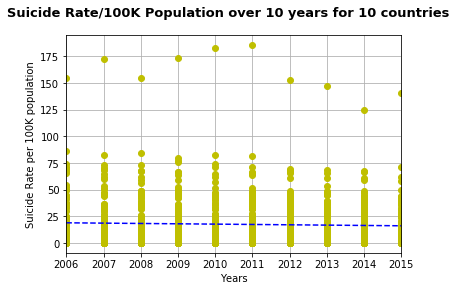

In [137]:
fig, ax = plt.subplots()

fig.suptitle("Suicide Rate/100K Population over 10 years for 10 countries", fontsize=13, fontweight="bold")

ax.set_xlim(min(year),max(year))


ax.set_xlabel("Years")
ax.set_ylabel("Suicide Rate per 100K population")

ax.plot(year, suicide_rate, linewidth=0, marker='o',color='y')
ax.plot(year, s_fit, 'b--')
plt.savefig("./Images/suicide_per100k_regressionline.png")
plt.grid()
plt.show()

In [20]:
#statistics
suicide_no=top_country_ten_yr_df['suicides_no']
mean_suicidestotal=np.mean(suicide_no)
mean_suicides_100K=np.mean(suicide_rate)
mid_suicidestotal=np.median(suicide_no)
mid_suicides_100K=np.median(suicide_rate)

print(f"Mean Suicide_nos: {mean_suicides_100K}")
print(f"Mean Suicide_rates: {mean_suicidestotal}")
print(f"Median Suicide_nos: {mid_suicidestotal}")
print(f"Median Suicide_rates: {mid_suicides_100K}")


Mean Suicide_nos: 17.630867346938786
Mean Suicide_rates: 1377.1530612244899
Median Suicide_nos: 731.5
Median Suicide_rates: 9.825


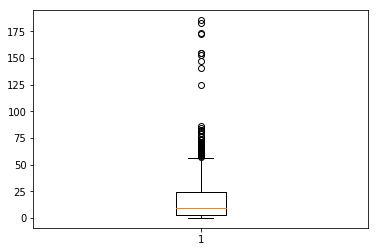

<Figure size 432x288 with 0 Axes>

In [181]:
#Creating boxplot to get outliers
plt.boxplot(suicide_rate)
plt.show()
plt.savefig("./Images/outliers.png")


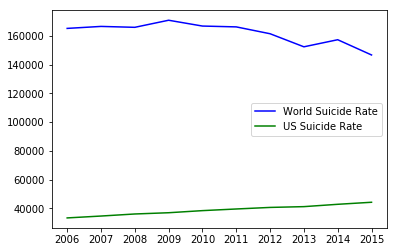

In [182]:
#creating a comparison
US_data=top_country_ten_yr_df.loc[top_country_ten_yr_df['country']=="United States"]
grouped_byyear=US_data.groupby('year')
us_sr=grouped_byyear['suicides_no'].sum()
us_sum=pd.DataFrame(us_sr)
world_data=top_country_ten_yr_df.groupby('year')
world_sr=world_data['suicides_no'].sum()
world_sum=pd.DataFrame(world_sr)

total_rate=pd.merge(world_sum,us_sum,how='inner',on='year')
years=total_rate_pd.index
total_rate_pd=total_rate.rename(columns={"suicides_no_x":"Global Suicide Numbers","suicides_no_y":"USA Suicide Numbers"})
total_rate_pd
world_sr=plt.plot(years,total_rate_pd['Global Suicide Numbers'] ,color="blue", label="World Suicide Rate" )
US_rate = plt.plot(years,total_rate_pd['USA Suicide Numbers'],color="green",label="US Suicide Rate")
plt.xticks(years)
plt.legend(loc="best")
plt.savefig("./Images/worldVsUS.png")

plt.show()